In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import sys
import os
import numpy as np
# sys.path.append("src")
sys.path.append(os.path.abspath('../'))
from src import data_pipeline, evaluation

output_dir = os.path.join('../', 'outputs')
os.makedirs(output_dir, exist_ok=True)

df = data_pipeline.load_data('../data/data.csv')

In [2]:
df = data_pipeline.clean_columns(df)

Index(['id', 'name', 'alias', 'gender', 'hair_color', 'love_rank', 'hate_rank',
       'eye_color', 'birthday', 'blood_type', 'tags', 'love_count',
       'hate_count', 'description', 'url'],
      dtype='object')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132028 entries, 0 to 132027
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           132028 non-null  int64  
 1   name         132028 non-null  object 
 2   alias        132028 non-null  object 
 3   gender       132028 non-null  object 
 4   hair_color   132028 non-null  object 
 5   love_rank    132028 non-null  float64
 6   hate_rank    132028 non-null  float64
 7   eye_color    132028 non-null  object 
 8   birthday     132028 non-null  object 
 9   blood_type   132028 non-null  object 
 10  tags         132028 non-null  object 
 11  love_count   132028 non-null  object 
 12  hate_count   132028 non-null  object 
 13  description  132027 non-null  object 
 14  url          132028 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 15.1+ MB


In [5]:
df = data_pipeline.clean_data(df)

Missing values before cleaning:
 id            0
name          0
gender        0
hair_color    0
love_rank     0
hate_rank     0
tags          0
love_count    0
hate_count    0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132028 entries, 0 to 132027
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          132028 non-null  int64  
 1   name        132028 non-null  object 
 2   gender      132028 non-null  object 
 3   hair_color  132028 non-null  object 
 4   love_rank   132028 non-null  float64
 5   hate_rank   132028 non-null  float64
 6   tags        132028 non-null  object 
 7   love_count  132028 non-null  int64  
 8   hate_count  132028 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 9.1+ MB


In [7]:
print(df.shape)

(132028, 9)


In [8]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_hair = LabelEncoder()

df['gender_encoded'] = le_gender.fit_transform(df['gender'])
df['hair_color_encoded'] = le_hair.fit_transform(df['hair_color'])

In [9]:
df.head()

,id,name,gender,hair_color,love_rank,hate_rank,tags,love_count,hate_count,gender_encoded,hair_color_encoded
0,0,L,male,black,1.000,48.000,"[Analytical, Barefoot, Detectives, Eye Bags, S...",44,3,1,0
1,1,Haru YOSHIDA,male,black,346.000,4.172,"[High School Students, Hot-Headed, Teenagers]",4,124,1,0
2,2,Shinobu MAEHARA,female,blue,2.942,9.110,"[Cooks, Crybabies, Middle School Students, Shy]",823,53,0,2
3,3,Chizuru OSHIMA,female,black,3.877,1.801,"[Class Representatives, Glasses, High School S...",633,269,0,0
4,4,Yuuzan YOSHIDA,male,black,3.577,2.819,[Adults],684,180,1,0


In [10]:
love_rank_cutoff = df['love_rank'].quantile(0.20)
love_count_cutoff = df['love_count'].quantile(0.80)
hate_rank_cutoff = df['hate_rank'].quantile(0.20)
hate_count_cutoff = df['hate_count'].quantile(0.80)

label_func = data_pipeline.label_character_factory(love_rank_cutoff, love_count_cutoff, hate_rank_cutoff, hate_count_cutoff)

df['label'] = df.apply(label_func, axis=1)
print(df['label'].value_counts())

label
Neutral      94399
Top Loved    25013
Top Hated    12616
Name: count, dtype: int64


In [11]:
print(df['tags'])

0         [Analytical, Barefoot, Detectives, Eye Bags, S...
1             [High School Students, Hot-Headed, Teenagers]
2           [Cooks, Crybabies, Middle School Students, Shy]
3         [Class Representatives, Glasses, High School S...
4                                                  [Adults]
                                ...                        
132023                                             [Adults]
132024                                    [Glasses, Adults]
132025      [Police, Martial Artists, Elderly, Facial Hair]
132026                                             [Adults]
132027                                             [Adults]
Name: tags, Length: 132028, dtype: object


In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['tags'])

# Create a DataFrame of binary tag columns
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

# Optional: limit to top N tags if too many
# tags_df = tags_df[tags_df.sum().sort_values(ascending=False).head(100).index]
# print(tags_df)

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Only apply PCA to the tag columns
tag_columns = tags_df.columns
tags_data = tags_df[tag_columns]

# PCA prefers scaled data (optional for binary, but helps when combining with numerical)
scaler = StandardScaler(with_mean=False)  # with_mean=False needed for sparse/binary
tags_scaled = scaler.fit_transform(tags_data)

# Apply PCA to reduce dimensionality (e.g., keep 50 components or 95% variance)
pca = PCA(n_components=50)  # or use n_components=0.95 to retain 95% variance
tags_pca = pca.fit_transform(tags_scaled)

print("Original tag dimensions:", tags_scaled.shape[1])
print("Reduced dimensions:", tags_pca.shape[1])

Original tag dimensions: 507
Reduced dimensions: 50


In [14]:
# Convert PCA array back to DataFrame
tags_pca_df = pd.DataFrame(tags_pca, columns=[f'pca_tag_{i}' for i in range(tags_pca.shape[1])])

# Concatenate with main df
df_reduced = pd.concat([df.reset_index(drop=True), tags_pca_df.reset_index(drop=True)], axis=1)

In [15]:
from sklearn.preprocessing import LabelEncoder

features = [
    'gender_encoded',
    'hair_color_encoded',
    'love_rank',
    'hate_rank',
    'love_count',
    'hate_count'
] + list(tags_pca_df.columns)

le_label = LabelEncoder()
df['label_encoded'] = le_label.fit_transform(df['label'])

# Optional: print mapping for reference
print(dict(zip(le_label.classes_, le_label.transform(le_label.classes_))))
df_reduced['label_encoded'] = df['label_encoded'].values


X = df_reduced[features]
y = df_reduced['label_encoded']

{'Neutral': np.int64(0), 'Top Hated': np.int64(1), 'Top Loved': np.int64(2)}


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

/Users/anveshradharapu/Documents/Project_Space/ML Engineer/MLEngineerPrep/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/anveshradharapu/Documents/Project_Space/ML Engineer/MLEngineerPrep/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Core metrics
metrics = evaluation.evaluate_classification(y_test, y_pred)
for metric, value in metrics.items():
    print(f"{metric.title()}: {value:.4f}")


Accuracy: 0.9962
Precision: 0.9929
Recall: 0.9934
F1_Score: 0.9932


In [18]:
try:
    auc = evaluation.evaluate_roc_auc(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print(f"Could not compute ROC-AUC: {e}")

ROC-AUC: 0.9998


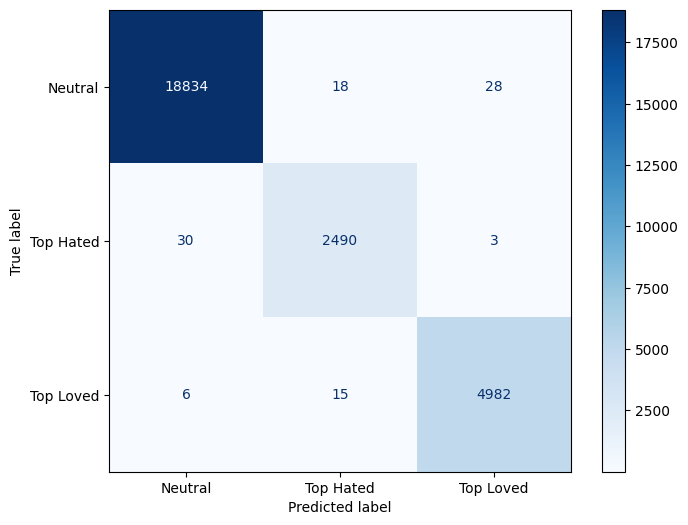

In [19]:
# Confusion matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_label.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues',ax=ax)
fig.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

In [21]:
evaluation.save_classification_reports(y_test, y_pred, output_dir)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18880
           1       0.99      0.99      0.99      2523
           2       0.99      1.00      0.99      5003

    accuracy                           1.00     26406
   macro avg       0.99      0.99      0.99     26406
weighted avg       1.00      1.00      1.00     26406

